In [ ]:
%%javascript
Jupyter.keyboard_manager.edit_shortcuts.remove_shortcut('Ctrl-X');

In [2]:
# imports
from contextlib import contextmanager
from collections import defaultdict, namedtuple

import pandas as pd
import numpy as np
import scipy as sp
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix

from polara.recommender.data import RecommenderData
from polara.recommender.models import RecommenderModel, SVDModel
from polara.recommender.coldstart.data import ItemColdStartData
from polara.tools.printing import print_frames
from polara.lib.similarity import combine_similarity_data
from evaluation import evaluate_hits
from tools import get_bx_data

from tqdm import tqdm_notebook

%matplotlib inline

In [3]:
# cholesky routines
cholesky_dense = lambda x: sp.linalg.cholesky(x, lower=True)
solve_triangular_dense = lambda L, V: sp.linalg.solve_triangular(L, V, lower=True, trans=1)
cholesky_factor_dense = lambda x: x

try:
    from scikits.sparse.cholmod import cholesky as cholesky_sparse
    # there's a problem in v.0.2 - factor.solve_Lt returns inaccurate result
    # have to use scipy's spsolve_triangular instead
    solve_triangular_sparse = lambda x, y: x.apply_Pt(sp.sparse.linalg.spsolve_triangular(x.L().T, y, lower=False))
    cholesky_factor_sparse = lambda x: x.apply_Pt(x.L())
except ImportError:
    print 'unable to import sparse cholesky module'
    pass

In [4]:
class ItemColdStartDataOld(RecommenderData):
    def __init__(self, *args, **kwargs):
        seed = kwargs.pop('seed', None)
        super(ItemColdStartDataOld, self).__init__(*args, **kwargs)

        self._test_sample = 1
        self._test_unseen_users = False

        self.seed = seed
        permute = np.random.RandomState(seed).permutation

        # build unique items list to split them by folds
        itemid = self.fields.itemid
        self._unique_items = permute(self._data[itemid].unique())


    def _check_state_transition(self):
        new_state, update_rule = super(ItemColdStartDataOld, self)._check_state_transition()
        if '_test_sample' in self._change_properties:
            update_rule['test_update'] = True
        return new_state, update_rule


    def _split_test_index(self):
        userid = self.fields.userid
        itemid = self.fields.itemid

        item_idx = np.arange(len(self._unique_items))
        cold_items_split = self._split_fold_index(item_idx, len(item_idx), self._test_fold, self._test_ratio)

        cold_items = self._unique_items[cold_items_split]
        cold_items_mask = self._data[itemid].isin(cold_items)
        return cold_items_mask


    def _split_data(self):
        assert self._test_ratio > 0
        assert not self._test_unseen_users
        update_rule = super(ItemColdStartDataOld, self)._split_data()

        if any(update_rule.values()):
            testset = self._sample_test_items()
            self._test = self._test._replace(testset=testset)
        return update_rule


    def _sample_test_items(self):
        userid = self.fields.userid
        itemid = self.fields.itemid
        itemid_cold = '{}_cold'.format(itemid)
        test_split = self._test_split
        holdout = self.test.evalset
        user_has_cold_item = self._data[userid].isin(holdout[userid].unique())
        testset = super(ItemColdStartDataOld, self)._sample_testset(user_has_cold_item, holdout.index)
        return testset


    def _sample_holdout(self, test_split):
        itemid = self.fields.itemid
        itemid_cold = '{}_cold'.format(itemid)
        return (self._data.loc[test_split, list(self.fields)]
                    .rename(columns={itemid: itemid_cold}, copy=False))


    def _try_drop_unseen_test_items(self):
        # there will be no such items except cold-start items
        pass

    def _try_drop_invalid_test_users(self):
        self._align_test_users() # ensure the same users are in both testset and holdout

    def _assign_test_items_index(self):
        itemid = self.fields.itemid
        self._map_entity(itemid, self._test.testset)
        self._reindex_cold_items() # instead of trying to assign known items index

    def _reindex_cold_items(self):
        itemid_cold = '{}_cold'.format(self.fields.itemid)
        cold_item_index = self.reindex(self.test.evalset, itemid_cold, inplace=True, sort=False)
        try: # check if already modified item index to avoid nested assignemnt
            item_index = self.index.itemid.training
        except AttributeError:
            item_index = self.index.itemid
        new_item_index = (namedtuple('ItemIndex', 'training cold_start')
                                ._make([item_index, cold_item_index]))
        self.index = self.index._replace(itemid=new_item_index)

In [62]:
class ColdStartHybridData(ItemColdStartDataOld):
    def __init__(self, sim_mat, sim_idx, *args, **kwargs):
        super(ColdStartHybridData, self).__init__(*args, **kwargs)

        entities = [self.fields.userid, self.fields.itemid]
        self._sim_idx = {entity: pd.Series(index=idx, data=np.arange(len(idx))) if idx is not None else None
                         for entity, idx in sim_idx.iteritems() if entity in entities}
        self._sim_mat = {entity: mat for entity, mat in sim_mat.iteritems() if entity in entities}
                
        self._side_similarity_weight = 0.999
        self._similarity = {entity:None for entity in entities}
        
        self._attach_model('on_change', self, '_on_change')
        self._attached_models['on_sim_weight_change'] = {self: '_on_change'}
        
        self._cold_items_similarity = None
        self._user_cold_item_similarity = None
        self._attach_model('on_update', self, '_clean_cold_similarity')
        
    
    def _on_change(self):
        self._clean_cold_similarity()
        self._clean_similarity()

    #def _reindex_cold_items(self):
    #    super(ColdStartHybridData, self)._reindex_cold_items()
    #   self._verify_cold_items()

    #def _sample_holdout(self, test_split):
    #    holdout = super(ColdStartHybridData, self)._sample_holdout(test_split)
    #    holdout = self._validate_cold_items(holdout)
    #    return holdout
        
    
    @property
    def features_weight(self):
        return self._side_similarity_weight

    @features_weight.setter
    def features_weight(self, new_val):
        if new_val != self._side_similarity_weight:
            self._side_similarity_weight = new_val
            self._notify('on_sim_weight_change')
    
    @property
    def item_similarity(self):
        itemid = self.fields.itemid
        return self.get_similarity(itemid)
    
    @property
    def user_similarity(self):
        userid = self.fields.userid
        return self.get_similarity(userid)
    
    def get_similarity(self, etnity):
        similarity = self._similarity.get(entity, None)
        if similarity is None:
            if self._sim_mat[entity] is None:
                self._similarity[entity] = None
            else:
                print 'Updating {} similarity'.format(entity)
                side_similarity = self._get_side_similarity(entity)
                full_similarity = self._build_total_similarity(side_similarity, inplace=True)
                self._similarity[entity] = full_similarity
        return self._similarity[entity]
    
    def _get_side_similarity(self, entity):
        # makes conversion of indices:
        # from data index to similarity matrix index
        entity_type = self.fields._fields[self.fields.index(entity)]
        index_data = getattr(self.index, entity_type)
        try:
            ext_idx = index_data.training['old'].values
        except AttributeError:
            ext_idx = index_data['old'].values
        
        sim_idx = self._sim_idx[entity]
        int_idx = sim_idx.loc[ext_idx].values
        #TODO avoid chained indexing - need to handle sparse and dense cases
        sim_mat = self._sim_mat[entity][:, int_idx][int_idx, :]
        return sim_mat

    def _build_total_similarity(self, side_similarity, inplace=False):
        side_weight = self._side_similarity_weight

        if inplace:
            side_similarity *= side_weight
        else:
            side_similarity = side_weight * side_similarity

        if sp.sparse.issparse(side_similarity):
            side_similarity.setdiag(1)
        else:
            np.fill_diagonal(side_similarity, 1)
        return side_similarity

    def _clean_similarity(self):
        self._similarity = {entity:None for entity in self._similarity.keys()}    
        
 
    def _clean_cold_similarity(self):
        self._user_cold_item_similarity = None
        self._cold_items_similarity = None

    #@property
    #def cold_items_similarity(self):
    #    itemid = self.fields.itemid
    #    
    #    if self._sim_mat[itemid] is None:
    #        self._cold_items_similarity = None
    #    elif self._cold_items_similarity is None:
    #        print 'Updating cold-start {} similarity'.format(itemid)
    #        item_index = self.index.itemid
    #        trn_idx = item_index.training.old.values
    #        cold_items_index = item_index.cold_start
    #        cld_idx = cold_items_index.old
    #        
    #        sim_idx = self._sim_idx[itemid]
    #        col_idx = sim_idx.loc[trn_idx].values
    #        row_idx = sim_idx.loc[cld_idx].values

    #        self._cold_items_similarity = self._sim_mat[itemid][:, col_idx][row_idx, :]
    #    return self._cold_items_similarity
    
    @property
    def user_cold_item_similarity(self):
        userid = self.fields.userid
        itemid = self.fields.itemid
        itemid_cold = '{}_cold'.format(itemid)
        sim_mat = self._sim_mat[itemid]
        
        if sim_mat is None:
            self._user_cold_item_similarity = None
        elif self._user_cold_item_similarity is None:
            userid = self.fields.userid
            print 'Updating {}-based cold-start {} similarity'.format(userid, itemid)
            
            sim_idx = self._sim_idx[itemid]
            seen_item_index = self.index.itemid.training
            similarity_matrix = sim_mat[:, sim_idx.loc[seen_item_index.old].values]
            
            holdout = self.test.evalset
            cold_item_index = self.index.itemid.cold_start
            useridx = np.r_[0, np.cumsum(np.diff(holdout[userid].values)>0)]
            itemidx = holdout[itemid_cold].map(cold_item_index.set_index('new').old)

            shape = (useridx.max() + 1, similarity_matrix.shape[0])
            data = np.ones_like(useridx)
            indicator_matrix = coo_matrix((data, (useridx, sim_idx.loc[itemidx].values)), shape=shape)
            
            self._user_cold_item_similarity = indicator_matrix.dot(similarity_matrix)
            has_meta = self._user_cold_item_similarity.getnnz(axis=1)>0
            if not has_meta.all():
                self._user_cold_item_similarity = self._user_cold_item_similarity[has_meta, :]
                holdout.loc[:, 'has_meta'] = np.repeat(has_meta, holdout[userid]
                                                                   .value_counts(sort=False)
                                                                   .sort_index().values)
        return self._user_cold_item_similarity

    cold_items_similarity = user_cold_item_similarity
    
    def _validate_cold_items(self, holdout):
        raise TypeError
        itemid = self.fields.itemid
        itemid_cold = '{}_cold'.format(itemid)
        sim_idx = self._sim_idx[itemid]
        
        trn_idx = self._data[itemid].drop(holdout.index).drop_duplicates().values
        col_idx = sim_idx.loc[trn_idx].values
        
        cld_idx = holdout[itemid_cold].drop_duplicates().values
        row_idx = sim_idx.loc[cld_idx].values
        
        cold_items_similarity = self._sim_mat[itemid][:, col_idx][row_idx, :]

        has_no_meta = cold_items_similarity.getnnz(axis=1) == 0
        if has_no_meta.any():
            no_meta_mask = holdout[itemid_cold].isin(cld_idx[has_no_meta])
            holdout = holdout.drop(holdout.index[no_meta_mask])
            if self.verbose:
                msg = '{} out of {} cold-start items were skipped. Reason: have no similarity information.'
                print msg.format(has_no_meta.sum(), len(has_no_meta))
        return holdout

    def _verify_cold_items(self):
        raise TypeError
        itemid = self.fields.itemid
        sim_idx = self._sim_idx[itemid]
        cold_items_index = self.index.itemid.cold_start
        holdout = self.test.evalset
        
        trn_idx = self.index.itemid.training.old.values
        col_idx = sim_idx.loc[trn_idx].values
        
        cld_idx = cold_items_index.old.values
        row_idx = sim_idx.loc[cld_idx].values
        
        cold_items_similarity = self._sim_mat[itemid][:, col_idx][row_idx, :]
        
        has_no_meta = cold_items_similarity.getnnz(axis=1) == 0
        if has_no_meta.any():
            cold_items_index.loc[:, 'no_meta'] = has_no_meta
            no_meta = cold_items_index.set_index('old')['no_meta']

            itemid_cold = '{}_cold'.format(itemid)
            no_meta_mask = holdout.loc[:, itemid_cold].map(no_meta)
            holdout.drop(holdout.index[no_meta_mask], inplace=True)
            if self.verbose:
                msg = '{} out of {} cold-start items were skipped. Reason: have no similarity information.'
                print msg.format(has_no_meta.sum(), len(has_no_meta))
        else:
            self._cold_items_similarity = cold_items_similarity

In [10]:
class HybridSVDColdStart(SVDModel):
    def __init__(self, *args, **kwargs):
        super(HybridSVDColdStart, self).__init__(*args, **kwargs)
        self.method = 'HybridSVD'
        entities = self.data.fields.userid, self.data.fields.itemid
        self._cholesky = {entity:None for entity in entities}
        self._sparse_mode = True
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def _on_change(self):
        super(HybridSVDColdStart, self)._on_change()
        self._clean_cholesky()

    @property
    def cholesky_factor(self):
        entity = self.data._entity_context
        cholesky = self._cholesky.get(entity, None)
        if cholesky is None:
            self._update_cholesky()
        return self._cholesky[entity]

    def _update_cholesky(self):
        full_similarity = self.data.similarity
        entity = self.data._entity_context
        if full_similarity is None:
            self._cholesky[entity] = None
        else:
            if self._sparse_mode:
                cholesky = cholesky_sparse
                mode = 'sparse'
            else:
                full_similarity = full_similarity.toarray()
                cholesky = cholesky_dense
                mode = 'dense'

            print 'Performing {} Cholesky decomposition for {} similarity'.format(mode, entity)
            self._cholesky[entity] = cholesky(full_similarity)

    def _clean_cholesky(self):
        self._cholesky = {entity:None for entity in self._cholesky.keys()} 

    def build(self):
        entity_context = self.data.entity_context
        userid = self.data.fields.userid
        itemid = self.data.fields.itemid
        
        with entity_context(userid):
            chol_users = self.cholesky_factor
        with entity_context(itemid):
            chol_items = self.cholesky_factor

        svd_matrix = self.get_training_matrix(dtype=np.float64)

        if self._sparse_mode:
            cholesky_factor = cholesky_factor_sparse
            solve_triangular = solve_triangular_sparse
        else:
            cholesky_factor = cholesky_factor_dense
            solve_triangular = solve_triangular_dense

        if chol_items is not None:
            cholesky_items = cholesky_factor(chol_items)
            svd_matrix = svd_matrix.dot(cholesky_items)

        if chol_users is not None:
            cholesky_users = cholesky_factor(chol_users)
            svd_matrix = cholesky_users.T.dot(svd_matrix)

        super(HybridSVDColdStart, self).build(operator=svd_matrix)

        if chol_items is not None:
            v = self._items_factors
            vs = cholesky_items.dot(v)
            vi = solve_triangular(chol_items, v)
            self._projector = (vs, vi)

    def slice_recommendations(self, test_data, shape, start, stop):
        raise NotImplementedError

    def get_recommendations(self):
        vs, vi = self._projector
        similarity_matrix = self.data.cold_items_similarity
        
        scores = similarity_matrix.dot(vs).dot(vi.T)
        if sp.sparse.issparse(scores):
            assert scores.format == 'csr'
        top_similar_items = self.get_topk_items(scores)
        return top_similar_items

    def get_similar_items(self, p):
        vs, vi = self._projector
        assert p.shape[0] == 1
        similarity_scores = p.dot(vs).dot(vi.T).squeeze()
        top_similar_items = self.topsort(similarity_scores, self.topk)
        return top_similar_items

In [11]:
class TopItemsColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(TopItemsColdStart, self).__init__(*args, **kwargs)
        self.method = 'mostpopular'
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def build(self):
        itemid = self.data.fields.itemid
        self.item_scores = self.data.training[itemid].value_counts(ascending=False)

    def get_recommendations(self):
        topk = self.topk
        similarity_matrix = self.data.cold_items_similarity
        top_items = self.item_scores.index[:topk].values
        top_items_array = np.lib.stride_tricks.as_strided(top_items,
                                                          (similarity_matrix.shape[0], topk),
                                                          (0, top_items.itemsize))
        return top_items_array

    def get_similar_items(self, p):
        return self.item_scores.index[:self.topk]

In [12]:
class RandomColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(RandomColdStart, self).__init__(*args, **kwargs)
        self.method = 'random'
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def build(self):
        self.all_items = self.data.index.itemid.training.new.values

    def get_recommendations(self):
        similarity_matrix = self.data.cold_items_similarity
        items_matrix = np.lib.stride_tricks.as_strided(self.all_items,
                                                       (similarity_matrix.shape[0], len(self.all_items)),
                                                       (0, self.all_items.itemsize))
        random_items = np.apply_along_axis(np.random.choice, 1, items_matrix, self.topk, replace=False)
        return random_items

    def get_similar_items(self, p):
        return np.random.choice(self.all_items, self.topk, replace=False)

In [13]:
class ContentBasedColdStart(RecommenderModel):
    def __init__(self, *args, **kwargs):
        super(ContentBasedColdStart, self).__init__(*args, **kwargs)
        self.method = 'CB'
        self.filter_seen = False # there are no seen items in cold-start recommendations

    def build(self):
        pass

    def get_recommendations(self):
        similarity_scores = self.data.cold_items_similarity.tocsr()
        top_similar_items = self.get_topk_items(similarity_scores)
        return top_similar_items

In [14]:
fp = "/home/evfro/hybrid_svd/BX-CSV-Dump.zip"

In [15]:
ratings, users, books = get_bx_data(fp, get_books=True, get_users=True)

In [17]:
implicit_data = ratings.query('rating==0').assign(rating=1)
valid_users = implicit_data.userid.value_counts().loc[lambda x: x<2000].index
implicit_data = implicit_data.query('userid in @valid_users')

In [18]:
valid_books = implicit_data.isbn.value_counts().loc[lambda x: x>1].index

In [19]:
bx_data = implicit_data.query('isbn in @valid_books')

In [20]:
books = (books[books.isbn.isin(bx_data.isbn.unique())]
         .set_index('isbn')
         .applymap(lambda x: [x,]))

missing_isbn = bx_data.isbn.drop_duplicates().loc[lambda x: ~x.isin(books.index)].values

books = books.append(pd.DataFrame(index=missing_isbn), ignore_index=False)
books.loc[missing_isbn, :] = books.loc[missing_isbn, :].applymap(lambda x: [])
books.index.name = 'isbn'

In [21]:
jw = 'jaccard-weighted'
jd = 'jaccard'
cs = 'cosine'
tc = 'tfidf-cosine'

sim_type = {'author':jd}
item_similarity = combine_similarity_data(books[sim_type.keys()], similarity_type=sim_type, weights=None)

In [22]:
similarities = {'userid': None, 'isbn': item_similarity}
sim_indices = {'userid': None, 'isbn': books.index}

In [63]:
seed = 13
data_model = ColdStartHybridData(similarities, sim_indices,
                                 bx_data, 'userid', 'isbn', 'rating',
                                 #random_state=np.random.RandomState(seed)
                                 seed=seed)

In [64]:
data_model.seed = seed
data_model.test_fold = 1
data_model.test_sample = None
data_model.features_weight = 0.999

In [65]:
data_model.prepare()

Preparing data...
5969 unique userid's within 6293 holdout interactions were filtered. Reason: not in the training data.


In [66]:
data_model.test.evalset.userid.nunique()

14463

In [67]:
data_model.user_cold_item_similarity

Updating userid-based cold-start isbn similarity


<12761x71945 sparse matrix of type '<type 'numpy.float64'>'
	with 1633179 stored elements in Compressed Sparse Row format>

In [69]:
cbcs = ContentBasedColdStart(data_model)
cbcs.build()

In [71]:
cb_hits = evaluate_hits(data_model.test.evalset.loc[lambda x: x['has_meta']], 'userid', 'isbn_cold', cbcs.recommendations)
cb_hr = cb_hits.getnnz(axis=1).mean()
cb_hr

0.00047018258757150694

In [101]:
cb_hits = evaluate_hits(data_model.test.testset, 'isbn_cold', 'isbn', cbcs.recommendations)
cb_hr = cb_hits.getnnz(axis=1).mean()
cb_hr

1.2876539045370214

In [226]:
print_frames((data_model.test.testset, data_model.test.evalset))

,userid,isbn,rating
10,1,24966,1
11,1,30142,1
13,1,38333,1
14,1,51585,1
15,1,51595,1
17,2,31867,1
22,2,62125,1
63,7,4256,1
104,11,42074,1
102,11,2892,1


In [108]:
assert not data_model.test.testset.isbn_cold.isin(data_model.index.itemid.cold_start.loc[lambda x: x.no_meta, 'new']).max()

In [113]:
def convert_index_inner(data, entity, index):
    pass
def convert_index_outer(data, entity, index):
    pass

In [145]:
assert data_model.test.testset.isbn_cold.nunique() == data_model.test.evalset.isbn_cold.nunique()
assert not (np.diff(data_model.test.testset.isbn_cold.values)<0).any()

In [72]:
hsvd = HybridSVDColdStart(data_model)

In [83]:
hsvd.rank = 1000
hsvd.build()

HybridSVD training time: 252.962176085s


In [74]:
hsvd_hits = evaluate_hits(data_model.test.evalset.loc[lambda x: x['has_meta']], 'userid', 'isbn_cold', hsvd.recommendations)

In [75]:
hsvd_hits.getnnz(axis=1).mean()

0.0010970927043335162

In [76]:
mpop = TopItemsColdStart(data_model)
mpop.build()

In [77]:
mpop_hits = evaluate_hits(data_model.test.evalset.loc[lambda x: x['has_meta']], 'userid', 'isbn_cold', mpop.recommendations)
mplr_hr = mpop_hits.getnnz(axis=1).mean()
mplr_hr

0.0011754564689287674

In [45]:
mpop_hits = evaluate_hits(data_model.test.testset, 'isbn_cold', 'isbn', mpop.recommendations)
mplr_hr = mpop_hits.getnnz(axis=1).mean()
mplr_hr

4.6830831506156185

In [84]:
svd_rank_results = defaultdict(list)
#psvd_f = psvd._items_factors.copy()
hsvd_p = tuple([f.copy() for f in hsvd._projector])
max_rank = hsvd_p[0].shape[1]
ranks = np.array([1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 17, 20, 25, 50, 75, 100, 150, 200, 300, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 3200])
for r in tqdm_notebook(ranks[ranks<=max_rank], desc='rank'):
    try:
        #psvd._items_factors = psvd._items_factors[:, :r]
        hsvd._projector = tuple([f[:, :r] for f in hsvd._projector])

        #psvd._recommendations = None
        hsvd._recommendations = None
        
        #svd_rank_results[psvd.method].append(evaluate_hits(data_model.test.testset, 'isbn_cold', 'isbn', psvd.recommendations).getnnz(axis=1).mean())
        svd_rank_results[hsvd.method].append(evaluate_hits(data_model.test.evalset.loc[lambda x: x['has_meta']], 'userid', 'isbn_cold', hsvd.recommendations).getnnz(axis=1).mean())
        #svd_rank_results[hsvd.method].append(evaluate_hits(data_model.test.testset, 'isbn_cold', 'isbn', hsvd.recommendations).getnnz(axis=1).mean())
    finally:
        #psvd._items_factors = psvd_f
        hsvd._projector = hsvd_p

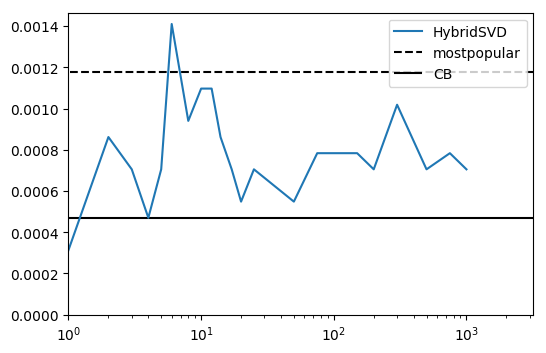

In [87]:
ax = pd.DataFrame(svd_rank_results, index=ranks[ranks<=max_rank]).plot(logx=True)
ax.hlines(mplr_hr, 0, 3200, linestyles='--', label=mpop.method)
ax.hlines(cb_hr, 0, 3200, linestyles='-', label=cbcs.method)
#ax.hlines(rand_hr, 0, 3200, linestyles=':', label=rndm.method)
ax.set_xlim(0, 3200)
ax.set_ylim(0, None)
ax.legend()

In [289]:
fold_res[data_model.test_fold] = (fold_results[data_model.test_fold][0][0], svd_rank_results)

In [290]:
mean_mplr_res = np.mean([v[0] for k, v in fold_res.iteritems()])
mean_hsvd_res = np.mean(np.array([v[1][hsvd.method]
                                  for k, v in fold_res.iteritems()]), axis=0)

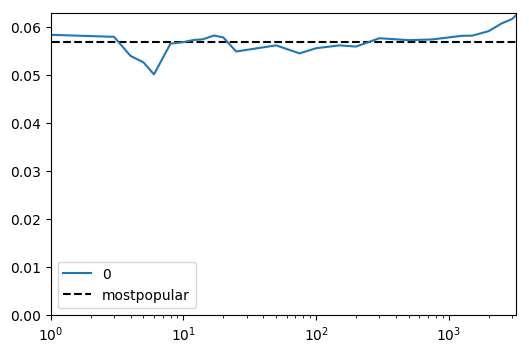

In [293]:
ax = pd.DataFrame(mean_hsvd_res, index=ranks).plot(logx=True)
ax.hlines(mean_mplr_res, 0, 3200, linestyles='--', label=mpop.method)
#ax.hlines(rand_hr, 0, 3200, linestyles=':', label=rndm.method)
ax.set_xlim(0, 3200)
ax.set_ylim(0, None)
ax.legend()

In [200]:
mean_mplr_results = np.mean([v[0][0] for k, v in fold_results.iteritems()])
mean_hsvd_results = np.mean(np.array([v[0][1][hsvd.method]
                                      for k, v in fold_results.iteritems()]), axis=0)

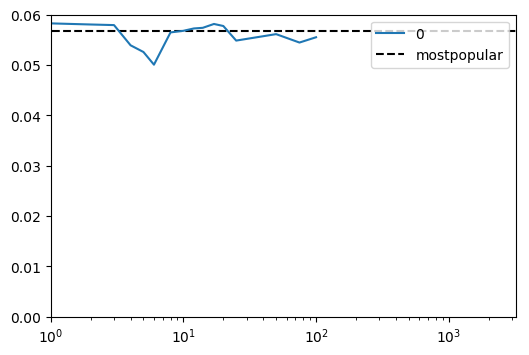

In [204]:
ax = pd.DataFrame(mean_hsvd_results, index=ranks[ranks<=max_rank]).plot(logx=True)
ax.hlines(mean_mplr_results, 0, 3200, linestyles='--', label=mpop.method)
#ax.hlines(rand_hr, 0, 3200, linestyles=':', label=rndm.method)
ax.set_xlim(0, 3200)
ax.set_ylim(0, 0.06)
ax.legend()

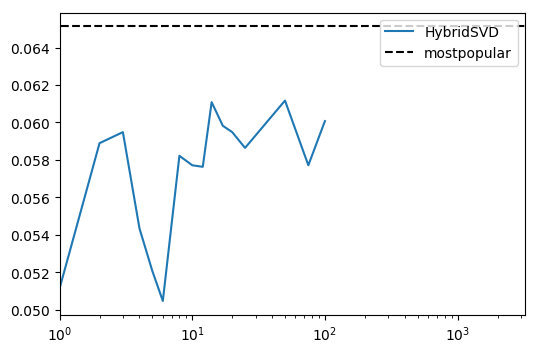

In [223]:
fold_data = fold_results[3][0]
ax = pd.DataFrame(fold_data[1], index=ranks[ranks<=100]).plot(logx=True)
ax.hlines(fold_data[0], 0, 3200, linestyles='--', label=mpop.method)
#ax.hlines(rand_hr, 0, 3200, linestyles=':', label=rndm.method)
ax.set_xlim(0, 3200)
ax.legend()

In [203]:
np.std([v[0][0] for k, v in fold_results.iteritems()])

0.013765957073823566

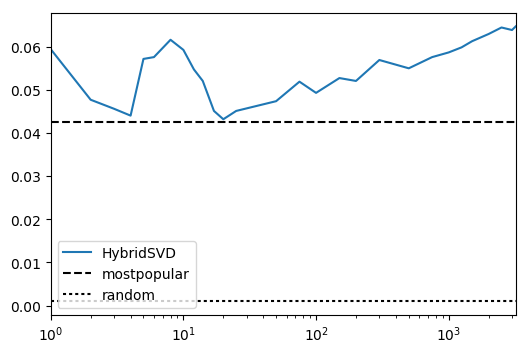

In [433]:
ax = pd.DataFrame(svd_rank_results, index=ranks).plot(logx=True)
ax.hlines(mplr_hr, min(ranks), max(ranks), linestyles='--', label=mpop.method)
ax.hlines(rand_hr, min(ranks), max(ranks), linestyles=':', label=rndm.method)
ax.legend()

In [82]:
pd.Series(data=svd_rank_results[hsvd.method], index=ranks[ranks<=max_rank]).sort_values(ascending=False)

6      0.001411
12     0.001097
10     0.001097
8      0.000940
14     0.000862
2      0.000862
100    0.000784
75     0.000784
25     0.000705
17     0.000705
5      0.000705
3      0.000705
50     0.000549
20     0.000549
4      0.000470
1      0.000313
dtype: float64